## Python Data fitting with various functions - HW 11 part 2 
Due Friday Nov 10, 2023


Dowload the data "miniDR17.fits" from the TCU Online Week 12:<br>
<i>NOTE: it is a large-ish file and may take a while.</i>

**However, this is a small version of the full science data file (4 GB) which can be found at:**<br>
https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStar-dr17-synspec_rev1.fits


You will be using the same data "miniDR17.fits" from the TCU Online Week 12:<br>

Remember you need to remove Identified bad data, 
however data that are just bad in one quantity may remain
Use masking to remove any remaining bad values (typically 9999 or -9999 in this file, <b>but remember to remove Outliers!!!!  If you are not sure, ask!!!</b>). 

In [4]:
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits 
import scipy.optimize as opt

# POTENTIAL FITTING FUNCTIONS
def linear(x,m,b):
    return m*x+b

def poly2(x,a,b,c):
    return a*(x**2)+(b*x)+c

def poly3(x,a,b,c,d):
    return (a*(x**3))+(b*(x**2))+(c*x)+d

def cosfit (x,a,b,c,d):
    return a*np.cos(b*x + c) + d

def exponential(x,a,b,c,d):
    return a*np.exp(b*x + c) + d

def logfit(x,a,b,c,d):
    return a*np.log(b*x + c) + d


# Monte Carlo-version of 2 parameter Curve Fit that can use BOTH x and Y errors
def mcFit2(func, x, y, x_err=0.1, y_err=0.1, p0=[0,0]):
    slope = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        slope.append(popt[0])
        y_ints.append(popt[1])
    return (np.median(slope),np.median(y_ints))


# Monte Carlo-version of 3 parameter Curve Fit that can use BOTH x and Y errors
def mcFit3(func, x, y, x_err=0.1, y_err=0.1,p0=[1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
    return (np.median(paramA),np.median(paramB),np.median(paramC))

# Monte Carlo-version of 4 parameter Curve Fit that can use BOTH x and Y errors
def mcFit4(func, x, y, x_err=0.1, y_err=0.1, p0=[1,1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    paramD = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
        paramD.append(popt[3])
    return (np.median(paramA),np.median(paramB),np.median(paramC),np.median(paramD))


In [5]:
# READ IN FITS FILES
star_hdus = fits.open('miniDR17.fits')
star = star_hdus[1].data
print(star_hdus[1].columns)
star_hdus.close()

ColDefs(
    name = 'APOGEE_ID'; format = '30A'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'TEFF'; format = 'E'
    name = 'TEFF_ERR'; format = 'E'
    name = 'LOGG'; format = 'E'
    name = 'LOGG_ERR'; format = 'E'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'SNR'; format = 'E'
    name = 'VHELIO_AVG'; format = 'E'
    name = 'VERR'; format = 'E'
    name = 'FE_H'; format = 'E'
    name = 'FE_H_ERR'; format = 'E'
    name = 'O_FE'; format = 'E'
    name = 'O_FE_ERR'; format = 'E'
    name = 'NI_FE'; format = 'E'
    name = 'NI_FE_ERR'; format = 'E'
    name = 'NVISITS'; format = 'J'
    name = 'VSCATTER'; format = 'E'
    name = 'ASPCAPFLAG'; format = 'K'
    name = 'STARFLAG'; format = 'K'
    name = 'EXTRATARG'; format = 'J'
    name = 'GAIA_PARALLAX'; format = 'E'
    name = 'GAIA_PARALLAX_ERROR'; for

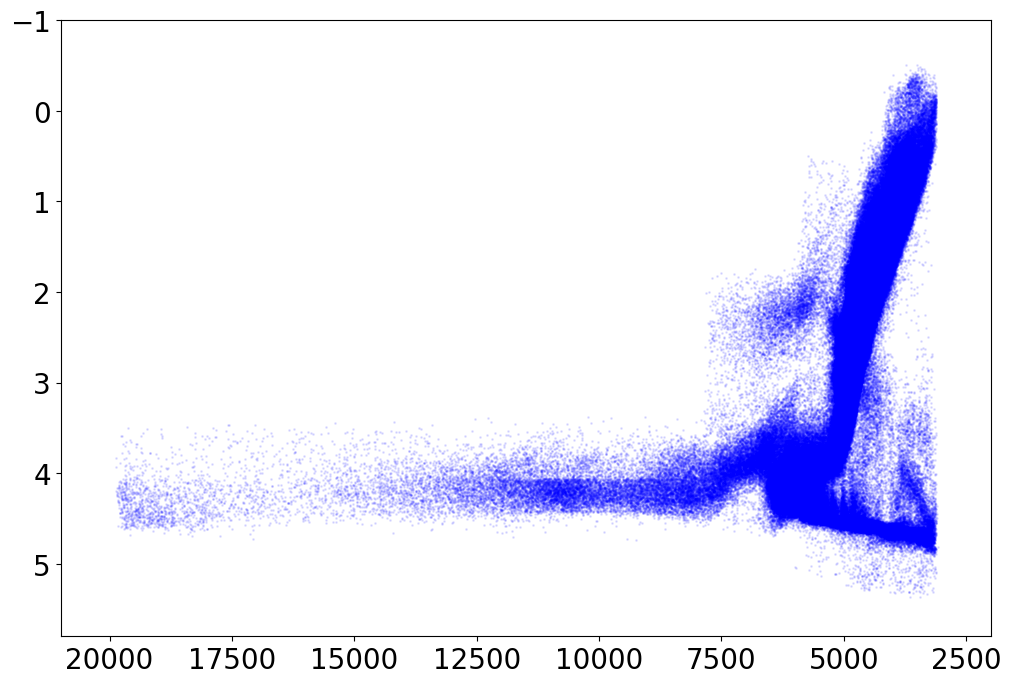

In [6]:
# TWO BITWISE FLAGS FOR BAD DATA - THESE REMOVE IDENTIFIED BAD DATA            
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

# Make a Boolena Mask to remove bad data
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0)
good = np.where(gd)[0]


# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter((star['TEFF'][good]),star['LOGG'][good],s=1,c='b',alpha=0.1)

ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.set_xlim(21000,2000)
ax.set_ylim(5.8,-1)

plt.show()

## DATA FIT 1

Fit a linear, polynomial (poly2), and a polynomial (poly3) functions and to the following selections of the data:
1. Select stars only with with $ GLAT > 20$ <br>
   __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR:  -0.22392383460589427 0.05625325344320181
POLY2:  -0.0611093405642513 -0.29336614254384974 0.051729232765765396
POLY3:  0.06680118542585875 0.08884377543401376 -0.2441574823247139 0.047853898630012506


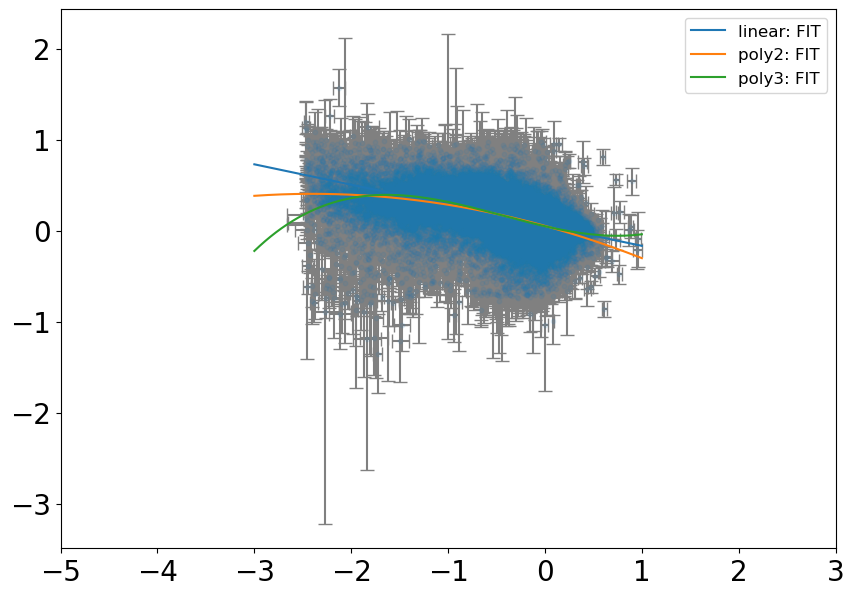

In [4]:
# TWO BITWISE FLAGS TO REMOVE FOR OBVIOUSLY BAD DATA             
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
      (np.bitwise_and(star['starflag'], suspectbits) == 0) &\
      (star['FE_H'] > -100) & (star['O_FE'] > -100) &\
      ((star['GLAT'] > 20))
      
cut1 = np.where(ct1)[0]

## Linear Fit: 

slope_1, intercept_1 = mcFit2(linear, star['Fe_H'][cut1], star['O_FE'][cut1], star['O_FE_ERR'][cut1], star['Fe_H_ERR'][cut1])
print("LINEAR: ",slope_1, intercept_1)

## Polynomial degree 2 Fit: 

param1_1_1, param1_2_1, param1_3_1 = mcFit3(poly2, star['Fe_H'][cut1], star['O_FE'][cut1], star['O_FE_ERR'][cut1], star['Fe_H_ERR'][cut1])
print("POLY2: ", param1_1_1, param1_2_1, param1_3_1)

## Polynomial degree 3 Fit:

param1_1_2, param1_2_2, param1_3_2, param1_4_2 = mcFit4(poly3, star['Fe_H'][cut1], star['O_FE'][cut1], star['O_FE_ERR'][cut1], star['Fe_H_ERR'][cut1])
print("POLY3: ", param1_1_2, param1_2_2, param1_3_2, param1_4_2)

fig_1 = plt.figure(figsize=(10,7)) ## figure plot
ax_1 = fig_1.add_subplot(111)

ax_1.scatter(star['FE_H'][cut1], star['O_FE'][cut1],s=10,alpha=0.1) 
ax_1.errorbar((star['Fe_H'][cut1]),star['O_FE'][cut1], xerr=(star['Fe_H_ERR'][cut1]), yerr=(star['O_FE_ERR'][cut1]), ecolor='grey',fmt='none', capsize=5, zorder=0)

ax_1.xaxis.set_tick_params(labelsize=20)
ax_1.yaxis.set_tick_params(labelsize=20)


# PLOT FITS
x_plot_1 = np.linspace(-3,1,1000) # X-PLOTING FOR FITS
#linear fit: 
ax_1.plot(x_plot_1,linear(x_plot_1, slope_1, intercept_1), label='linear: FIT')
#poly2 fit: 
ax_1.plot(x_plot_1,poly2(x_plot_1, param1_1_1, param1_2_1, param1_3_1), label='poly2: FIT')

#poly3 fit: 
ax_1.plot(x_plot_1,poly3(x_plot_1, param1_1_2, param1_2_2, param1_3_2, param1_4_2), label='poly3: FIT')

ax_1.set_xlim(-5,3)

plt.legend(loc='best', fontsize=12)
plt.show()

In [17]:
print ("Linear fit would be the best")

Linear fit would be the best


## DATA FIT 2

Fit a linear, polynomial (poly2), and a polynomial (poly3) functions and to the following selections of the data:
2. Select stars only with with $-1< GLAT < 1$ <br>
   __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR:  -0.18442019322989545 0.05970778431616569
POLY2:  -0.04254012579446039 -0.23038579610450852 0.05738938206442373
POLY3:  0.003955956883698384 -0.033031023063187386 -0.22819602107751868 0.05686954523583575


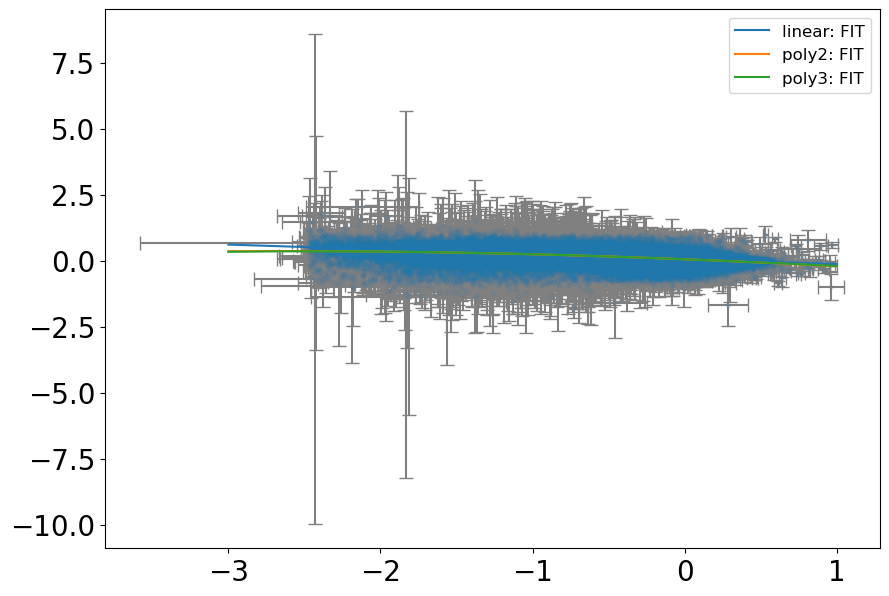

In [7]:
# TWO BITWISE FLAGS TO REMOVE FOR OBVIOUSLY BAD DATA             
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
ct2 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
      (np.bitwise_and(star['starflag'], suspectbits) == 0) &\
      (star['FE_H'] > -100) & (star['O_FE'] > -100) &\
      ((star['GLAT'] < -1) | (star['GLAT'] > 1))
      
cut2 = np.where(ct2)[0]

## Linear Fit: 

slope_2, intercept_2 = mcFit2(linear, star['Fe_H'][cut2], star['O_FE'][cut2], star['O_FE_ERR'][cut2], star['Fe_H_ERR'][cut2])
print("LINEAR: ",slope_2, intercept_2)

## Polynomial degree 2 Fit: 

param2_1_1, param2_2_1, param2_3_1 = mcFit3(poly2, star['Fe_H'][cut2], star['O_FE'][cut2], star['O_FE_ERR'][cut2], star['Fe_H_ERR'][cut2])
print("POLY2: ", param2_1_1, param2_2_1, param2_3_1)

## Polynomial degree 3 Fit:

param2_1_2, param2_2_2, param2_3_2, param2_4_2 = mcFit4(poly3, star['Fe_H'][cut2], star['O_FE'][cut2], star['O_FE_ERR'][cut2], star['Fe_H_ERR'][cut2])
print("POLY3: ", param2_1_2, param2_2_2, param2_3_2, param2_4_2)

## create figures

fig_2 = plt.figure(figsize=(10,7)) ## figure plot
ax_2 = fig_2.add_subplot(111)

## plot the raw data and error bars

ax_2.scatter(star['FE_H'][cut2], star['O_FE'][cut2],s=10,alpha=0.1) 
ax_2.errorbar((star['Fe_H'][cut2]),star['O_FE'][cut2], xerr=(star['Fe_H_ERR'][cut2]), yerr=(star['O_FE_ERR'][cut2]), ecolor='grey',fmt='none', capsize=5, zorder=0)

ax_2.xaxis.set_tick_params(labelsize=20)
ax_2.yaxis.set_tick_params(labelsize=20)


# PLOT FITS
x_plot_2 = np.linspace(-3,1,1000) # X-PLOTING FOR FITS
#linear fit: 
ax_2.plot(x_plot_2,linear(x_plot_2, slope_2, intercept_2), label='linear: FIT')
#poly2 fit: 
ax_2.plot(x_plot_2,poly2(x_plot_2, param2_1_1, param2_2_1, param2_3_1), label='poly2: FIT')
#poly3 fit: 
ax_2.plot(x_plot_2,poly3(x_plot_2, param2_1_2, param2_2_2, param2_3_2, param2_4_2), label='poly3: FIT')

plt.legend(loc='best', fontsize=12)
plt.show()


In [21]:
print("All function fits are good for the graph")

All function fits are good for the graph


## DATA FIT 3

Fit a linear, polynomial (poly3), and a exponetial functions and to the following selections of the data:
3. Select stars only with with $340 < GLON < 360$ <br>
   __Fit TEFF,  (TEFF\_ERR)  vs.  LOGG (LOGG\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR:  0.00044336831364206195 0.3542136309327617
POLY3:  4.465906769926055e-12 -1.7373901635758565e-07 0.0021236765376350295 -4.023693692744812


C:\Users\furgy\AppData\Local\Temp\ipykernel_6468\982337099.py:20: RuntimeWarning: overflow encountered in exp
  return a*np.exp(b*x + c) + d
C:\Users\furgy\AppData\Local\Temp\ipykernel_6468\982337099.py:20: RuntimeWarning: overflow encountered in multiply
  return a*np.exp(b*x + c) + d
C:\Users\furgy\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


EXPONENTIAL:  -23.49044620591387 -0.0003476165449790422 -0.7605425872325837 4.728925869573736


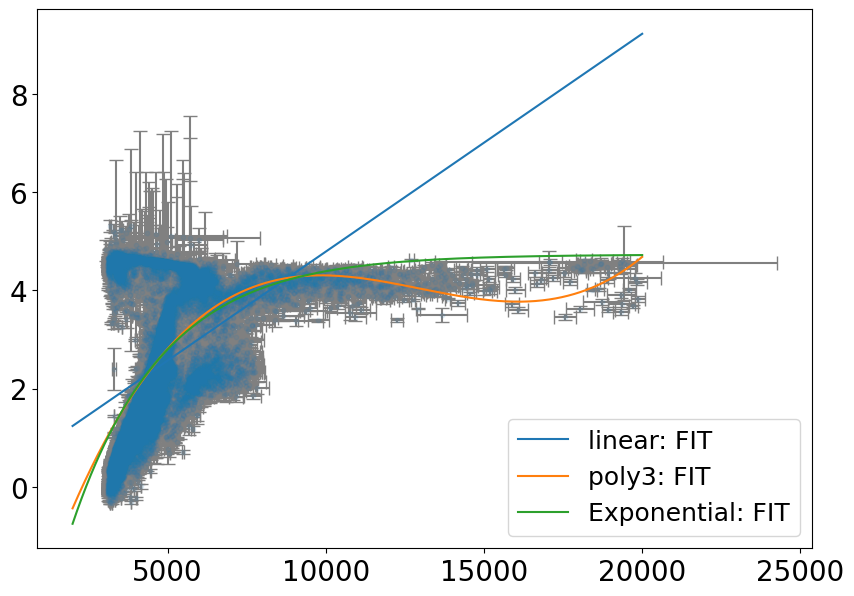

In [40]:

# TWO BITWISE FLAGS TO REMOVE FOR OBVIOUSLY BAD DATA             
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

ct3 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
      (np.bitwise_and(star['starflag'], suspectbits) == 0) &\
      (star['GLON'] < 360) & (star['GLON'] > 340) &\
      (star['TEFF'] > 1000) & (star['LOGG'] > -1000)
cut3 = np.where(ct3)[0]


#Linear Fit: 

slope, intercept = mcFit2(linear, star['TEFF'][cut3], star['LOGG'][cut3], star['TEFF_ERR'][cut3], star['LOGG_ERR'][cut3])
print("LINEAR: ",slope, intercept)

#Polynomial degree 3 Fit:

param1_1, param1_2, param1_3, param1_4 = mcFit4(poly3, star['TEFF'][cut3], star['LOGG'][cut3], star['TEFF_ERR'][cut3], star['LOGG_ERR'][cut3])
print("POLY3: ", param1_1, param1_2,param1_3, param1_4)

#Exponential Fit: 

param2_1, param2_2, param2_3, param2_4 =  mcFit4(exponential, star['TEFF'][cut3], star['LOGG'][cut3], star['TEFF_ERR'][cut3], \
                         star['LOGG_ERR'][cut3]
(print("EXPONENTIAL: ", param2_1, param2_2,param2_3, param2_4))

## create figures

fig_3 = plt.figure(figsize=(10,7))
ax_3 = fig_3.add_subplot(111)

## plot the raw data and error bars

ax_3.scatter(star['TEFF'][cut3], star['LOGG'][cut3],s=10,alpha=0.1) 
ax_3.errorbar((star['TEFF'][cut3]),star['LOGG'][cut3], xerr=(star['TEFF_ERR'][cut3]), yerr=(star['LOGG_ERR'][cut3]), ecolor='grey',fmt='none', capsize=5, zorder=0)

ax_3.xaxis.set_tick_params(labelsize=20)
ax_3.yaxis.set_tick_params(labelsize=20)

# PLOT FITS
x_plot = np.linspace(2000,20000,1000) # X-PLOTING FOR FITS
#linear fit: 
ax_3.plot(x_plot,linear(x_plot, slope, intercept), label='linear: FIT')

#poly3 fit: 
ax_3.plot(x_plot,poly3(x_plot,param1_1, param1_2,param1_3, param1_4), label='poly3: FIT')

#exponential fit: 
ax_3.plot(x_plot,exponential(x_plot, param2_1, param2_2,param2_3, param2_4), label='Exponential: FIT')

plt.legend(loc='best', fontsize=18)
plt.show()


In [41]:
print ("The Exponential fit if the best for this graph ")

The Exponential fit if the best for this graph 


## DATA FIT 4

Fit  a linear, a logfit, and a polynomial (poly2) functions and to the following selections of the data:
4. Select stars only with with $DEC < -50$ and $50 < RA < 120$ <br>
   __Fit TEFF,  (TEFF\_ERR)   vs.  (J - K) (J\_ERR, K\_ERR)__<br>
<br>
NOTE: you will have to create a (J-K) error:  JK_ERR = np.sqrt( J\_ERR^2 + K\_ERR^2 )<br> 

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR:  -0.0001570489424870687 1.546586258651344
POLY2:  2.1412535476627188e-08 -0.0005012983453489858 2.6944168049854387
POLY3:  1.1606961911863715e-12 -5.575898803621685e-09 9.327384094415248e-05 1.39033523570021


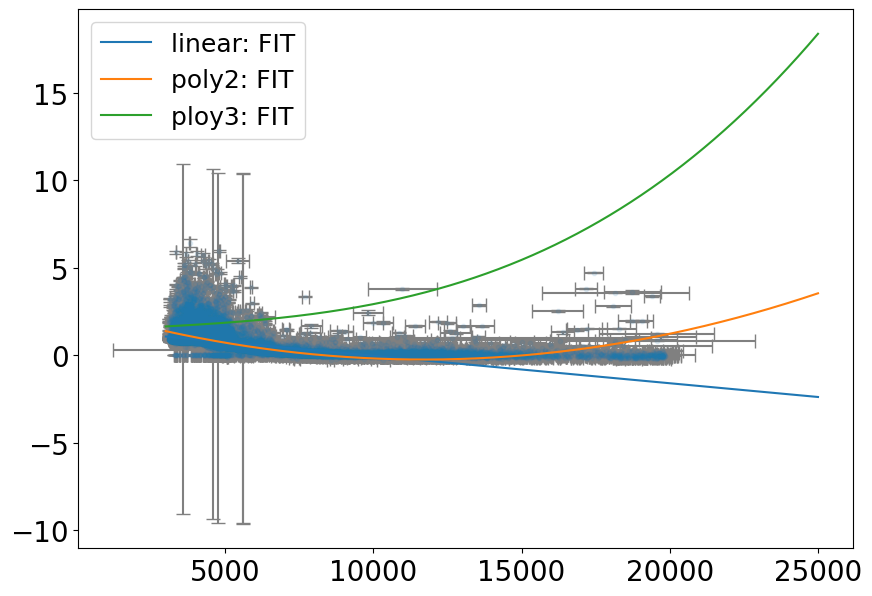

In [50]:
# TWO BITWISE FLAGS TO REMOVE FOR OBVIOUSLY BAD DATA             
badbits = 2**24        # aspcapstar flag - Chemistry (changed 3 to 4)
suspectbits = 2**16    # star flag - Stellar parameters

ct4 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
      (np.bitwise_and(star['starflag'], suspectbits) == 0) &\
      (star['DEC'] < -50) & (star['RA'] > 50) & (star['RA'] < 120) &\
      (star['TEFF'] > 1000) & (star['J']) & (star['K']) & (star['J_ERR']) & (star['K_ERR'])
cut4 = np.where(ct4)[0]

JK_ERR = np.sqrt(star['J_ERR'][cut4]**2 + star['K_ERR'][cut4]**2)

# Linear Fit: 

slope, intercept = mcFit2(linear, star['TEFF'][cut4], star['J'][cut4]-star['K'][cut4], star['TEFF_ERR'][cut4], \
                          JK_ERR, p0=[0,0])
print("LINEAR: ", slope, intercept)

# Polynomial degree 2 Fit:

param1_1, param1_2, param1_3 = mcFit3(poly2, star['TEFF'][cut4], star['J'][cut4]-star['K'][cut4], star['TEFF_ERR'][cut4], \
                         JK_ERR,p0=[1,1,1])
print("POLY2: ", param1_1, param1_2, param1_3)

#Polynomial degree 3 Fit:

param2_1, param2_2, param2_3, param2_4 =  mcFit4(poly3, star['TEFF'][cut4], star['J'][cut4]-star['K'][cut4], star['TEFF'][cut4], \
                         star['TEFF'][cut4],p0=[1,1,1,0])
print("POLY3: ", param2_1, param2_2,param2_3, param2_4)

## create figures

fig_4 = plt.figure(figsize=(10,7))
ax_4 = fig_4.add_subplot(111)

## plot the raw data and error bars

ax_4.scatter(star['TEFF'][cut4], star['J'][cut4]-star['K'][cut4], s=10, alpha=0.1) 
ax_4.errorbar((star['TEFF'][cut4]), star['J'][cut4]-star['K'][cut4], xerr=(star['TEFF_ERR'][cut4]), yerr=JK_ERR, ecolor='grey', fmt='none', capsize=5, zorder=0)

ax_4.xaxis.set_tick_params(labelsize=20)
ax_4.yaxis.set_tick_params(labelsize=20)

# PLOT FITS
x_plot = np.linspace(3000, 25000, 1000) # X-PLOTING FOR FITS
# linear fit: 
ax_4.plot(x_plot, linear(x_plot, slope, intercept), label='linear: FIT')

# poly2 fit: 
ax_4.plot(x_plot, poly2(x_plot, param1_1, param1_2, param1_3), label='poly2: FIT')

ax_4.plot(x_plot, poly3(x_plot, param2_1, param2_2,param2_3, param2_4), label = 'ploy3: FIT')

plt.legend(loc='best', fontsize=18)
plt.show()


In [51]:
print ("Poly2 line fit is the best function line that fits the graph")

Poly2 line fit is the best function line that fits the graph


## DATA FIT 5

Fit  a linear, a polynomial (poly3), and a cosfit functions and to the following selections of the data:
5. Select stars only with with $-10< GLAT < 10$<br>
   __Fit GLON  vs.  VHEILO\_AVG (VERR)__<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR:  0.0036870473787999985 -5.076070779285131
POLY3:  -2.846932045250887e-05 0.014741714617845523 -1.8456852593803486 28.481653379982063
COSFIT:  -6.135351321115943 0.9801582322862773 1.4603553222308188 -4.291306685867327


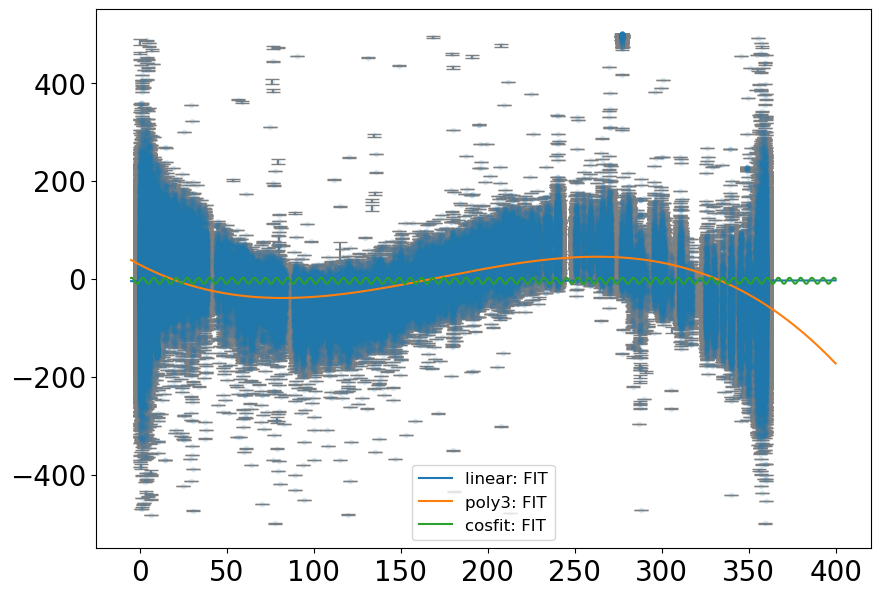

In [14]:
# TWO BITWISE FLAGS TO REMOVE FOR OBVIOUSLY BAD DATA             
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

ct5 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
      (np.bitwise_and(star['starflag'], suspectbits) == 0) &\
      (star['GLAT'] > -10) & (star['GLAT'] < 10) &\
      (star['VHELIO_AVG'] < 500) & (star['VHELIO_AVG'] > -500)
      
      
cut5 = np.where(ct5)[0]

## Linear Fit: 

slope_5, intercept_5 = mcFit2(linear, star['GLON'][cut5], star['VHELIO_AVG'][cut5], star['VERR'][cut5])
print("LINEAR: ",slope_5, intercept_5)

# Polynomial degree 3 Fit:
param5_1_2, param5_2_2, param5_3_2, param5_4_2 = mcFit4(poly3, star['GLON'][cut5], star['VHELIO_AVG'][cut5], star['VERR'][cut5])
print("POLY3: ", param5_1_2, param5_2_2, param5_3_2, param5_4_2)

## Cosine Fit: 

param5_1_3, param5_2_3, param5_3_3, param5_4_3 = mcFit4(cosfit, star['GLON'][cut5], star['VHELIO_AVG'][cut5], star['VERR'][cut5])
print("COSFIT: ", param5_1_3, param5_2_3, param5_3_3, param5_4_3)

## create the figures and graphs:

fig_5 = plt.figure(figsize=(10,7)) ## figure plot
ax_5 = fig_5.add_subplot(111)

## plot the raw data and error bars

ax_5.scatter(star['GLON'][cut5], star['VHELIO_AVG'][cut5],s=10,alpha=0.1) 
ax_5.errorbar(star['GLON'][cut5], star['VHELIO_AVG'][cut5], yerr=(star['VERR'][cut5]), ecolor='grey',fmt='none', capsize=5, zorder=0)

ax_5.xaxis.set_tick_params(labelsize=20)
ax_5.yaxis.set_tick_params(labelsize=20)

# PLOT FITS
x_plot_5 = np.linspace(-5,400,1000) # X-PLOTING FOR FITS
#linear fit: 
ax_5.plot(x_plot_5,linear(x_plot_5, slope_5, intercept_5), label='linear: FIT')
#poly3 fit: 
ax_5.plot(x_plot_5,poly3(x_plot_5, param5_1_2, param5_2_2, param5_3_2, param5_4_2), label='poly3: FIT')
#cosine fit:
ax_5.plot(x_plot_5,cosfit(x_plot_5, param5_1_3, param5_2_3, param5_3_3, param5_4_3), label='cosfit: FIT')

plt.legend(loc='best', fontsize=12)
plt.show()


In [18]:
print ("Poly 3 function fit is the best for the graph")

Poly 3 function fit is the best for the graph


## DATA FIT 6

Fit a linear, an exponential, and a polynomial (poly3) functions and to the following selections of the data:
6. __Fit NVISITS vs.  VSCATTER (VERR)__ For NVISITS $>= 1$<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

In [56]:
# TWO BITWISE FLAGS TO REMOVE FOR OBVIOUSLY BAD DATA             
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

ct6 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
      (np.bitwise_and(star['starflag'], suspectbits) == 0) &\
      (star['NVISITS'] > 1)
      
cut6 = np.where(ct6)[0]

## Linear Fit: 

slope_6, intercept_6 = mcFit2(linear, star['NVISITS'][cut6], star['VSCATTER'][cut6], star['VERR'][cut6])
print("LINEAR: ",slope_6, intercept_6)

## Polynomial degree 3 Fit:

param6_1_2, param6_1_2, param6_1_3, param6_1_4 = mcFit4(poly3, star['NVISITS'][cut6], star['VSCATTER'][cut6], star['VERR'][cut6])
print("POLY3: ", param6_1_2, param6_1_2, param6_1_3, param6_1_4)

## Exponential Fit: 

param6_2_1, param6_2_2, param6_2_3, param6_2_4 =  mcFit4(exponential, star['NVISITS'][cut6], star['VSCATTER'][cut6], star['VERR'][cut6])
                      
print("EXPONENTIAL: ", param6_2_1, param6_2_2, param6_2_3, param6_2_4)

## create figures and graphs:

fig_6 = plt.figure(figsize=(10,7)) ## figure plot
ax_6 = fig_6.add_subplot(111)

## plot the raw data and error bars:

ax1.scatter(star['NVISITS'][cut1],star['VSCATTER'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['NVISITS'][cut1]),star['VSCATTER'][cut1], yerr=((star['VERR'][cut1])), ecolor='grey',fmt='none', capsize=5, zorder=0)
ax_6.xaxis.set_tick_params(labelsize=20)
ax_6.yaxis.set_tick_params(labelsize=20)

x_plot = np.linspace(0,70,1000)

# PLOT FITS
#linear fit: 
ax_6.plot(x_plot_6,linear(x_plot_6, slope_6, intercept_6), label='linear: FIT')
#poly3 fit: 
ax_6.plot(x_plot_6,poly3(x_plot_6, param6_1_2, param6_1_2, param6_1_3, param6_1_4), label='poly3: FIT')
#exponential fit 
ax_6.plot(x_plot_6, exponential(x_plot_6,param6_2_1, param6_2_2, param6_2_3, param6_2_4 ), label = 'exponential: FIT')

plt.legend(loc='best', fontsize=12)
plt.show()


KeyboardInterrupt: 

## DATA FIT 7

Fit  a linear and a polynomial (poly2 AND poly3) functions and to the following selections of the data:
7. __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  NI\_FE (NI\_FE\_ERR)__<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR:  0.012710330802199802 0.015565873899079584
POLY2:  0.02387516289770856 0.037089586570855246 0.01670206380756515
POLY3:  -0.019691828333409656 -0.01616247475647961 0.026275071010677775 0.018134499359117644


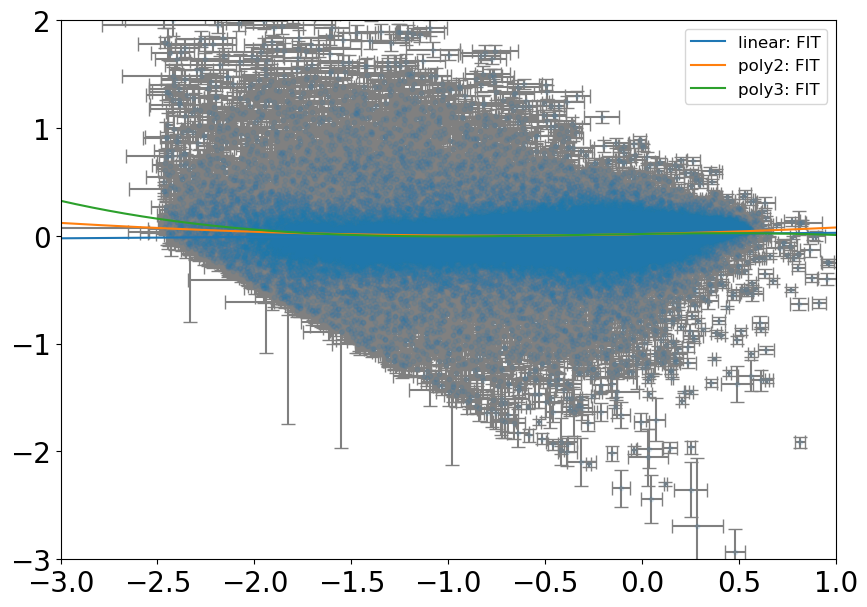

In [16]:
# TWO BITWISE FLAGS TO REMOVE FOR OBVIOUSLY BAD DATA             
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

ct7 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
      (np.bitwise_and(star['starflag'], suspectbits) == 0) &\
      (star['FE_H'] > -1000) & (star['NI_FE'] > -1000)
      
cut7 = np.where(ct7)[0]


## Linear Fit: 

slope_7, intercept_7 = mcFit2(linear, star['Fe_H'][cut7], star['NI_FE'][cut7], star['NI_FE_ERR'][cut7], star['Fe_H_ERR'][cut7])
print("LINEAR: ",slope_7, intercept_7)

## Polynomial degree 2 Fit: 

param7_1_1, param7_1_2, param7_1_3 = mcFit3(poly2, star['Fe_H'][cut7], star['NI_FE'][cut7], star['NI_FE_ERR'][cut7], star['Fe_H_ERR'][cut7])
print("POLY2: ", param7_1_1, param7_1_2, param7_1_3)

## Polynomial degree 3 Fit:
param7_2_1, param7_2_2, param7_2_3, param7_2_4 = mcFit4(poly3, star['Fe_H'][cut7], star['NI_FE'][cut7], star['NI_FE_ERR'][cut7], star['Fe_H_ERR'][cut7])
print("POLY3: ", param7_2_1, param7_2_2, param7_2_3, param7_2_4)


## create figures

fig_7 = plt.figure(figsize=(10,7)) ## figure plot
ax_7 = fig_7.add_subplot(111)

## plot the raw data and error bars

ax_7.scatter(star['FE_H'][cut7], star['NI_FE'][cut7],s=10,alpha=0.1) 
ax_7.errorbar((star['Fe_H'][cut7]),star['NI_FE'][cut7], xerr=(star['Fe_H_ERR'][cut7]), yerr=(star['NI_FE_ERR'][cut7]), ecolor='grey',fmt='none', capsize=5, zorder=0)

ax_7.xaxis.set_tick_params(labelsize=20)
ax_7.yaxis.set_tick_params(labelsize=20)

# PLOT FITS
x_plot_7 = np.linspace(-3,1,1000) # X-PLOTING FOR FITS
#linear fit: 
ax_7.plot(x_plot_7,linear(x_plot_7, slope_7, intercept_7), label='linear: FIT')
#poly2 fit: 
ax_7.plot(x_plot_7,poly2(x_plot_7, param7_1_1, param7_1_2, param7_1_3), label='poly2: FIT')
#poly3 fit: 
ax_7.plot(x_plot_7,poly3(x_plot_7, param7_2_1, param7_2_2, param7_2_3, param7_2_4), label='poly3: FIT')

ax_7.set_xlim(-3.0,1)
ax_7.set_ylim(-3.0,2)

plt.legend(loc='best', fontsize=12)
plt.show()


In [55]:
print("I would say that either linear and poly2 function line is the best fit for the graph")

I would say that either linear and poly2 function line is the best fit for the graph
